In [517]:
import numpy as np
import itertools
from matplotlib import pyplot as plt

In [518]:
class tensor:
    def __init__(self, fromArray=np.zeros((2,2)), _children = (), _operation = ''):
        fromArray = fromArray if isinstance(fromArray, np.ndarray) else np.array(fromArray)
        #assert len(fromArray.shape) == 2, "Only 2D Tensors or Scalar to 2D Supported!"
        self.matrix = fromArray
        #self.rows = fromArray.shape[0]
        #self.columns = fromArray.shape[1]
        self.shape = fromArray.shape
        self._prev = set(_children)
        self._operation = _operation
        self._backward = lambda : None
        self.grad = None


    def __repr__(self):
        return f"Tensor Values = {self.matrix}"
    
    @classmethod
    def zeros(cls, shape, dtype = np.float32):
        t = tensor()
        t.matrix = np.zeros(shape, dtype=dtype)
        t.shape = shape
        #t.rows = rows
        #t.columns = columns
        return t
    
    @classmethod
    def random(cls, shape, dtype = np.float32):
        t = tensor()
        t.matrix = (np.random.randn(*shape) * 0.1).astype(dtype=dtype)
        t.shape = shape
        return t
    
    @classmethod
    def const(cls, shape, constant=1, dtype = np.float32):
        t = tensor()
        t.matrix = (np.full(shape, constant)).astype(dtype=dtype)
        t.shape = shape
        #t.rows = rows
        #t.columns = columns
        return t
    
    #Operations
    def __add__(self, other):
        other = self.checkOther(other)
        out_matrix = self.matrix + other.matrix

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            other.grad = np.zeros_like(other.matrix) if other.grad is None else other.grad
            out1 = self.return_unbroadcasted(out)
            out2 = other.return_unbroadcasted(out)
            self.grad += out1 #Derivation in the notes. 
            other.grad += out2
        out = tensor(out_matrix, (self, other), '+')
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        other = self.checkOther(other)
        return self + (-1 * other)
    
    
    def __rsub__(self, other):
        other = self.checkOther(other)
        return other + (-1 * other)
    

    def __mul__(self, other):
        other = self.checkOther(other)
        out_matrix = self.matrix * other.matrix
        def _backward():
            self.grad = np.zeros_like(out.grad) if self.grad is None else self.grad
            other.grad = np.zeros_like(out.grad) if other.grad is None else other.grad
            out1 = self.return_unbroadcasted(out)
            out2 = other.return_unbroadcasted(out)
            self.grad += out1* other.matrix #Derivation in the notes. 
            other.grad += out2 * self.matrix

        out = tensor(out_matrix, (self, other), '*')
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __matmul__(self, other):
        other = other if isinstance(other, tensor) else tensor(other)
        assert other.shape[-2] == self.shape[-1], f"Dimensions Unsupported for @, {self.shape} vs {other.shape}"
        out_matrix = self.matrix @ other.matrix
        def _backward():
            self.grad = np.zeros_like(self.matrix, dtype=float) if self.grad is None else self.grad
            other.grad = np.zeros_like(other.matrix, dtype=float) if other.grad is None else other.grad
            self.grad += out.grad @ (other.matrix).transpose()#Derivation in the notes.
            other.grad += (self.matrix).transpose() @ out.grad 
        out = tensor(out_matrix, (self, other), '@')
        out._backward = _backward
        return out
    
    def __rmatmul__(self, other):
        other = other if isinstance(other, tensor) else tensor(other)
        return other @ self
    
    def transpose(self):
        out_matrix = self.matrix.transpose()
        
        def _backward():
            self.grad = np.zeros_like(out.grad.transpose()) if self.grad is None else self.grad
            self.grad += (out.grad).transpose() #Not in note, but can be derived similarly.

        out = tensor(out_matrix, (self, ), 'T')
        out._backward = _backward

        return out
    
    def __pow__(self, N):
        assert isinstance(N, int | float), "Can only power up by scalars!"
        out_matrix = self.matrix ** N

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            out1 = self.return_unbroadcasted(out)
            self.grad += N * (self.matrix ** (N-1)) * out1
        
        out = tensor(out_matrix, _children=(self, ), _operation="**")
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        other = self.checkOther(other)
        return self * (other**-1)
    
    def __rtruediv__(self, other):
        return other * (self**-1)
    
    def sum(self):
        out_matrix = np.array(([[self.matrix.sum()]]))

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += np.ones_like(self.matrix) * out.grad

        out = tensor(out_matrix, _children=(self, ), _operation='sum()')
        out._backward = _backward
        return out

    def mean(self):
        N = np.prod(self.shape)
        out_matrix = np.array(([[self.matrix.sum()/(N)]]))

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += np.ones_like(self.matrix) * out.grad / N

        out = tensor(out_matrix, _children=(self, ), _operation='mean()')
        out._backward = _backward
        return out
    
    def ReLU(self):
        out_matrix = np.maximum(0,self.matrix)

        def _backward():
            self.grad = np.zeros_like(self.matrix) if self.grad is None else self.grad
            self.grad += (self.matrix > 0).astype(self.matrix.dtype) * out.grad

        out = tensor(out_matrix, (self, ), "ReLU")
        out._backward = _backward
        return out
    
    #Helper Functions
    #def shape(self):
     #   return (self.rows, self.columns)

    def return_unbroadcasted(self, out):  
        added_axis = []
        stretched_axis = []
        for index, (first_no, second_no) in enumerate(itertools.zip_longest(reversed(self.shape), reversed(out.shape))):
            if first_no is None:
                added_axis.append(index)
            elif (first_no == 1) and (second_no > 1):
                stretched_axis.append(index)
        grad = out.grad
        ndim = len(out.shape)
        if stretched_axis:
            original_axes = tuple(ndim - 1 - i for i in stretched_axis)
            grad = np.sum(grad, axis=original_axes, keepdims=True)
        if added_axis:
            original_axes = tuple(ndim - 1 - i for i in added_axis)
            grad = np.sum(grad, axis=original_axes, keepdims=False)
        return grad

    def checkOther(self, other):
        if isinstance(other, int | float):
            other = tensor.const(self.shape, other)
        elif not isinstance(other, tensor):
            other = tensor(other)
        #assert other.shape == self.shape, "Operand Tensor sizes dont match"

        return other
    
    def zero_grad(self):
        self.grad = None
        
    def backward(self):
        self.grad = np.ones_like(self.matrix, dtype=float)
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for current in reversed(topo):

            current._backward()

    __array_ufunc__ = None

In [519]:
a = [[1,2],[3,4]]
b = [[5,6],[7,8]]

c = np.array(a) @ tensor(b)
c
#a = tensor(a)
#a


Tensor Values = [[19 22]
 [43 50]]

In [520]:
class Layer:
    def __init__(self, in_features, out_features): #Naming inspired by torch :)
        self.weights = tensor.random((in_features, out_features))
        self.bias = tensor.zeros((1, out_features))

    def __call__(self, X):
        X = X if isinstance(X, tensor) else tensor(X)
        act = (X @ self.weights + self.bias)
        return act
    
    def parameters(self):
        return [self.weights, self.bias]
    
    def zero_grad(self):
        self.weights.zero_grad()
        self.bias.zero_grad()

In [521]:
l = Layer(4,1)
l.parameters

<bound method Layer.parameters of <__main__.Layer object at 0x157e43620>>

In [522]:
class FCN:
    def __init__(self, input_features, output_features_list):
        sizes = [input_features] + output_features_list
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)]
        
    def __call__(self, X):
        for i, layer in enumerate(self.layers):
            X = layer(X)
            # ReLU only for hidden layers
            if i < len(self.layers) - 1:
                X = X.ReLU()
        return X

    def zero_grad(self):
        for layer in self.layers:
            layer.zero_grad()
    
    def fit(self, X, Y, epochs, lr):
        TrainLoss = []
        for epoch in range(epochs):
            self.zero_grad()
            Ypredicted = self(X)
            Loss = ((Ypredicted - Y)**2).mean()
            Loss.backward()
            
            for layer in self.layers:
                layer.weights = layer.weights + (-lr * layer.weights.grad)
                layer.bias = layer.bias + (-lr * layer.bias.grad)
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {np.sqrt(Loss.matrix.item())}")
            TrainLoss.append((epoch, np.sqrt(Loss.matrix.item())))
        return TrainLoss

In [540]:
input_features = 3
output_features_list = [4, 5, 6, 1]

nn = FCN(input_features, output_features_list)


Epoch 0, Loss: 1.1331882352344382


/var/folders/vx/0mwc7nyn64x7k2f0jlg9hs300000gn/T/ipykernel_45216/4015905270.py:53: RuntimeWarning: overflow encountered in add
  self.grad += out1 #Derivation in the notes.
/var/folders/vx/0mwc7nyn64x7k2f0jlg9hs300000gn/T/ipykernel_45216/4015905270.py:54: RuntimeWarning: overflow encountered in add
  other.grad += out2


Epoch 100, Loss: 1.1174755838854955


/var/folders/vx/0mwc7nyn64x7k2f0jlg9hs300000gn/T/ipykernel_45216/4015905270.py:53: RuntimeWarning: invalid value encountered in add
  self.grad += out1 #Derivation in the notes.
/var/folders/vx/0mwc7nyn64x7k2f0jlg9hs300000gn/T/ipykernel_45216/4015905270.py:54: RuntimeWarning: invalid value encountered in add
  other.grad += out2


Epoch 200, Loss: 1.1167966400044649
Epoch 300, Loss: 1.1147603639079566
Epoch 400, Loss: 1.105171432620701
Epoch 500, Loss: 1.0009425072444051
Epoch 600, Loss: 0.5143156539867193
Epoch 700, Loss: 0.1616657583013646
Epoch 800, Loss: 0.08105111642554456
Epoch 900, Loss: 0.04695860097678019


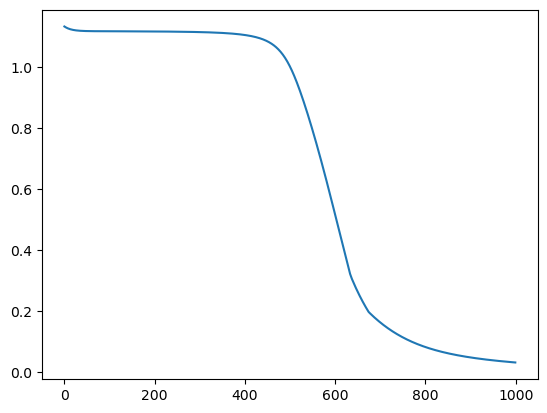

In [542]:
X = np.array([[0.0, 1.0, 2.0],
              [1.0, 2.0, 3.0],
              [2.0, 3.0, 4.0],
              [3.0, 4.0, 5.0]], dtype=float)
Y = np.array([[1.0], [2.0], [3.0], [4.0]], dtype=float)

#4x3 . 3x4 = 4x4
#4x4 . 4x5 = 4x5
#4x5 . 5x6 = 4x6
#4x6 . 6x1 = 4x1

lossTuple = nn.fit(X, Y, 1000, 0.01)
x_coords, y_coords = zip(*lossTuple)
plt.plot(x_coords, y_coords)


In [543]:
nn(X)

Tensor Values = [[1.05932713]
 [1.98877576]
 [2.99738624]
 [4.00618149]]

In [535]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
df = pd.read_csv("USA_Housing.csv")
X = df.iloc[:, :5]
Y = df.iloc[:, 5:6]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#Y_train = Y_train / Y_train.max()
#Y_test = Y_test / Y_test.max()


In [536]:
input_features = 5
output_features_list = [1]

nn = FCN(input_features, output_features_list)

Epoch 0, Loss: 1277895.9596660752
Epoch 100, Loss: 101212.32784049347
Epoch 200, Loss: 101211.97819911971


/var/folders/vx/0mwc7nyn64x7k2f0jlg9hs300000gn/T/ipykernel_45216/4015905270.py:53: RuntimeWarning: overflow encountered in add
  self.grad += out1 #Derivation in the notes.
/var/folders/vx/0mwc7nyn64x7k2f0jlg9hs300000gn/T/ipykernel_45216/4015905270.py:54: RuntimeWarning: overflow encountered in add
  other.grad += out2


Epoch 300, Loss: 101211.9781933697
Epoch 400, Loss: 101211.97819336959
Epoch 500, Loss: 101211.9781933696


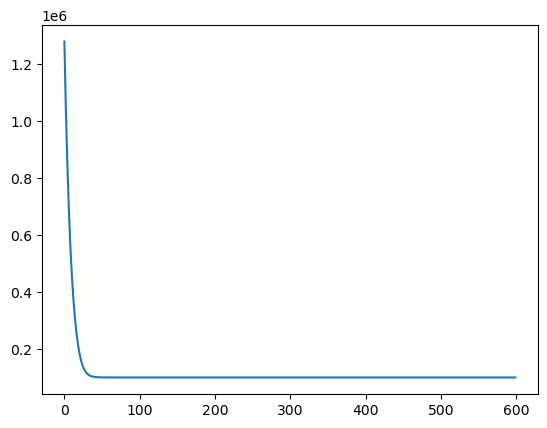

In [537]:
lossTuple = nn.fit(X_train, Y_train, 600, 5e-2)
x_coords, y_coords = zip(*lossTuple)
plt.plot(x_coords, y_coords)

0.9185061197290606


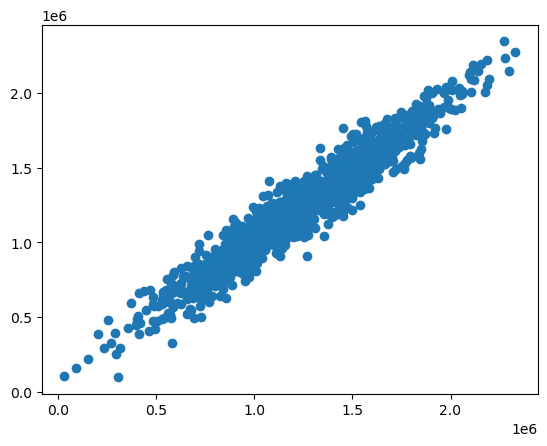

In [538]:
Y_predicted = nn(X_test)
print(r2_score(Y_test, Y_predicted.matrix))
plt.scatter(Y_test, Y_predicted.matrix)

Done. FCN/MLP implemented !